# Neural Ordinary Differential Equations for Chaotic Systems

The double pendulum is a physical system which exhibits chaotic behaviour (for some initial conditions). As the name suggests, it consists of two masses connected by fixed rods which swing under gravity.

Diagram of the double pendulum system:

![](https://dassencio.org/assets/double-pendulum.483b215e.svg)

We will consider the simplified system where $m_1 = m_2$ and $l_1 = l_2$.

The dynamics of this system are described by the equations of motion:

$$ \mathbf{y} = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dot{\theta}_1 \\ \dot{\theta}_2 \end{bmatrix} \ \ , \ \ \frac{d \mathbf{y}}{dt} = \begin{bmatrix} \dot{\theta}_1 \\ \dot{\theta}_2 \\ f_1(\theta_1,\theta_2) \\ f_2(\theta_1,\theta_2) \end{bmatrix} $$

Where $\theta_1$ and $\theta_2$ are the angles of the pendula (see diagram), dotted variables denote time derivatives and $f_1$ and $f_2$ are the angular force functions, which we will treat as unknown.

## Problem statement

Your task is to:

 - Write a neural differential equation system for the double pendulum system.
 - Train this model on data produced by direct numerical solutions to the true double pendulum system.
 - Understand the training and behaviour of NDEs and investigate their behaviour for chaotic systems.

In [46]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import diffrax
import time
import optax
import equinox as eqx

from DoublePendulumSolver import DoublePendulum as DPS

In [ ]:
def generate_training_data(Nsamples, theta_range, omega_range, tmax, L = 1.0, Nt = 1000, key = jax.random.PRNGKey(42)):
    key,subkey = jax.random.split(key)
    y0s = jax.random.uniform(subkey,shape=(Nsamples,4))
    y0s = y0s.at[:,:2].set(theta_range[0] + (theta_range[1]-theta_range[0])*y0s[:,:2])
    y0s = y0s.at[:,2:].set(omega_range[0] + (omega_range[1]-omega_range[0])*y0s[:,2:])
    
    ts = jnp.linspace(0.0,tmax,Nt)
    DP = DPS(ts=ts)

    init_cond = {
        'theta1' : y0s[:,0],
        'theta2' : y0s[:,1],
        'theta1dot' : y0s[:,2],
        'theta2dot' : y0s[:,3],
        }
    
    args = {'L' : L}

    ys = jax.jit(jax.vmap(DP.__call__,in_axes=[0,None]))(init_cond, args)
    return ts, ys

In [ ]:
theta_range = [-jnp.pi/2.0,jnp.pi/2.0]
omega_range = [0.0,0.0]
Nsamples = 10000
tmax = 10.0

ts, training_ys = generate_training_data(Nsamples, theta_range, omega_range, tmax)

In [ ]:
import matplotlib.pyplot as plt

plt.hist2d(training_ys['theta1'].flatten(),training_ys['theta2'].flatten(),bins=[jnp.linspace(-jnp.pi/2,jnp.pi/2,1000),jnp.linspace(-jnp.pi/2,jnp.pi/2,1000)],vmax=100,cmap='cubehelix')
plt.colorbar()
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')

Below we will define our Neural Differential Equation module using jax and libraries (most notably equinox and diffrax). 

In [2]:
class NeuralODE_RHS(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=in_size,
            out_size=out_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.leaky_relu,
            key=key,
            use_bias=False,
            use_final_bias=False
        )

    def __call__(self, t, y, args):
        _y_unpack = jnp.array([y['theta1'], y['theta2']])
        dydt = self.mlp(_y_unpack)
        return {
        'theta1' : y['theta1dot'],
        'theta2' : y['theta2dot'],
        'theta1dot' : dydt[0],
        'theta2dot' : dydt[1],
        }

class NeuralODE(eqx.Module):
    in_size: int
    func: NeuralODE_RHS

    def __init__(self, in_size, out_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.in_size = in_size
        self.func = NeuralODE_RHS(in_size, out_size, width_size, depth, key=key)

    def __call__(self, ts, y0, args):
        """
        Similar to our examples above, we set up diffeqsolve
        but now our ODETerm uses our NeuralODE_RHS equinox Module.
        """
        # Add relevant data to the args dictionary
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=args,
            stepsize_controller=diffrax.PIDController(rtol=args['rtol'], atol=args['rtol']),
            saveat=diffrax.SaveAt(ts=ts),
            max_steps=int(1e6)
        )
        return solution.ys

Here we define a function to perform training on our NDE model based on input training data. This training function involves 3 key strategies:

1. Batching of NDE solves over training data
2. A stepwise learning rate schedule
3. A stepwise training data truncation schedule

In [6]:
def train_DPNDE(ts,ys,args,
    model,
    optimiser,
    lr_strategy,
    steps_strategy,
    length_strategy,
    print_every=50
):
    length_size = ts.shape[0]

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        # Handle batch
        batched_model = jax.vmap(model,in_axes=(None,0,None))
        y0 = jax.tree.map(lambda v : v[:,0], yi)
        y_pred = batched_model(ti, y0, args)
        MSE = jnp.mean((jax.flatten_util.ravel_pytree(y_pred)[0]-jax.flatten_util.ravel_pytree(yi)[0])**2)
        return MSE

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    count = 0
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optimiser(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = jax.tree.map(lambda v : v[:,:int(length_size * length)], ys)
        for step in range(steps):
            count += 1
            start = time.time()
            loss, model, opt_state = make_step(_ts, _ys, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    return model

Here we can define our base model and learning strategy

In [29]:
base_model = NeuralODE(in_size=2, out_size=2, width_size=16, depth=3, key=jax.random.PRNGKey(420))

NDE_args = {'rtol' : 1e-3, 'atol' : 1e-6}

optimiser = optax.adam
lr_strategy = [1e-2,1e-2,1e-2,1e-3]
steps_strategy = [100,100,100,100]
length_strategy = [0.1,0.25,0.4,0.5]

trained_model = base_model

## Problems

- Train a model on a single training data example, what happens if you try to train on full time series (length_strategy = 1.0) from epoch 0?
- Perform a test-train split and train the model and evaluate its performance.
- Can you improve this model via modifying the hyper parameters?

In [30]:
trained_model = train_DPNDE(ts,jax.tree.map(lambda v : v[:10,:], training_ys),NDE_args,trained_model,
    optimiser,lr_strategy,steps_strategy,length_strategy)

Step: 0, Loss: 2.476944905763961, Computation time: 10.15174674987793
Step: 50, Loss: 0.4552536154962018, Computation time: 0.006514310836791992
Step: 99, Loss: 0.28853536465249036, Computation time: 0.006506919860839844
Step: 0, Loss: 1.0794563608673426, Computation time: 8.643871545791626
Step: 50, Loss: 0.719961346614164, Computation time: 0.012691497802734375
Step: 99, Loss: 0.678566958535895, Computation time: 0.012093305587768555
Step: 0, Loss: 0.92108089293701, Computation time: 9.523064136505127
Step: 50, Loss: 0.6873306531436424, Computation time: 0.015349388122558594
Step: 99, Loss: 0.6303896927554195, Computation time: 0.020555496215820312
Step: 0, Loss: 0.6558412844020648, Computation time: 8.574813842773438
Step: 50, Loss: 0.61200007098371, Computation time: 0.021587610244750977
Step: 99, Loss: 0.6043383649804873, Computation time: 0.02007436752319336


### Chaotic trajectories

For some values of initial conditions, the double pendulum can show chaotic trajectories. In other words, small perturbations to the initial conditions lead to large variation in trajectories. Let us look at a specific example:

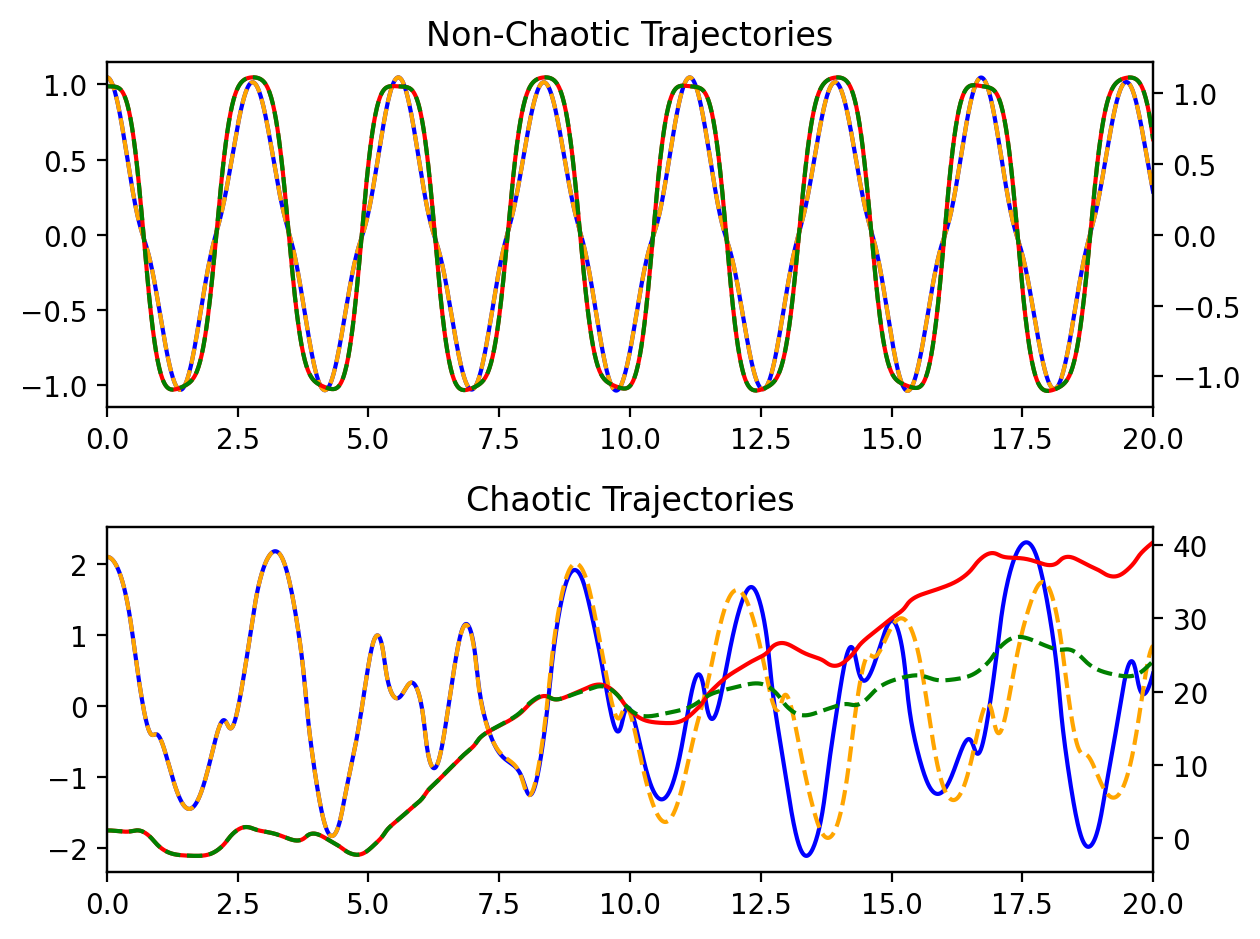

In [67]:
ts_chaos = jnp.linspace(0.0,20.0,2000)

DP_chaos = DPS(ts=ts_chaos)

args = {'L' : 1.0}

init_cond = {
    'theta1' : 1.0*jnp.pi/3.0,
    'theta2' : 1.0*jnp.pi/3.0,
    'theta1dot' : 0.0,
    'theta2dot' : 0.0,
    }

init_cond_perturb = {k : (1+1e-5)*v for k,v in init_cond.items()}

ys_nochaos_1 = DP_chaos(init_cond, args)
ys_nochaos_2 = DP_chaos(init_cond_perturb, args)

init_cond = {
    'theta1' : 2.0*jnp.pi/3.0,
    'theta2' : 1.0*jnp.pi/3.0,
    'theta1dot' : 0.0,
    'theta2dot' : 0.0,
    }

init_cond_perturb = {k : (1+1e-5)*v for k,v in init_cond.items()}

ys_chaos_1 = DP_chaos(init_cond, args)
ys_chaos_2 = DP_chaos(init_cond_perturb, args)

fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212,sharex=ax1)

ax1t = ax1.twinx()
ax2t = ax2.twinx()

ax1.plot(ts_chaos,ys_nochaos_1['theta1'],label='Theta 1 - Unperturbed',color='blue')
ax1.plot(ts_chaos,ys_nochaos_2['theta1'],label='Theta 1 - Perturbed',color='orange',ls='--')

ax1t.plot(ts_chaos,ys_nochaos_1['theta2'],label='Theta 2 - Unperturbed',color='red')
ax1t.plot(ts_chaos,ys_nochaos_2['theta2'],label='Theta 2 - Perturbed',color='green',ls='--')

ax2.plot(ts_chaos,ys_chaos_1['theta1'],label='Theta 1 - Unperturbed',color='blue')
ax2.plot(ts_chaos,ys_chaos_2['theta1'],label='Theta 1 - Perturbed',color='orange',ls='--')

ax2t.plot(ts_chaos,ys_chaos_1['theta2'],label='Theta 2 - Unperturbed',color='red')
ax2t.plot(ts_chaos,ys_chaos_2['theta2'],label='Theta 2 - Perturbed',color='green',ls='--')

ax1.set_title('Non-Chaotic Trajectories')
ax2.set_title('Chaotic Trajectories')

ax1.set_xlim([ts_chaos[0],ts_chaos[-1]])
fig.tight_layout()

## Extension problems:

- How does your trained model perform on chaotic trajectories? What issue will likely arise if a model is only trained on a short timeframe (e.g. [0,10]) given what is shown in the example above?
- Produce training data including chaotic trajectories () and see how the NDE model trains.
- What implications does this have more ML models of chaotic systems e.g. weather?